In [ ]:
import io
import json
import requests
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def crawl_price(stock_id):

    d = datetime.datetime.now()
    url = "https://query1.finance.yahoo.com/v8/finance/chart/"+stock_id+"?period1=0&period2="+str(int(d.timestamp()))+"&interval=1d&events=history&=hP2rOschxO0"

    res = requests.get(url)
    data = json.loads(res.text)
    df = pd.DataFrame(data['chart']['result'][0]['indicators']['quote'][0], index=pd.to_datetime(np.array(data['chart']['result'][0]['timestamp'])*1000*1000*1000))
    return df



twii = crawl_price("^TWII")
twii.head()

,low,close,open,high,volume
1997-07-02 01:00:00,8988.129883,8996.719727,9094.269531,9124.299805,0.0
1997-07-03 01:00:00,8997.509766,9027.629883,9061.599609,9061.599609,0.0
1997-07-04 01:00:00,9119.250000,9192.570312,9144.959961,9218.209961,0.0
1997-07-07 01:00:00,9304.820312,9322.839844,9365.190430,9370.410156,0.0
1997-07-08 01:00:00,9282.099609,9305.269531,9345.549805,9371.500000,0.0


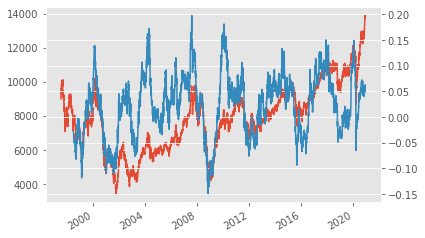

In [ ]:
mean = twii['close'].pct_change().rolling(252).mean()
std = twii['close'].pct_change().rolling(252).std()

sharpe = mean / std

twii.close.plot()
sharpe.plot(secondary_y=True)

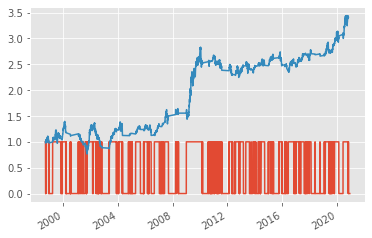

In [ ]:
import numpy as np

# sharpe ratio 平滑
sr = sharpe
srsma = sr.rolling(60).mean()

# sharpe ratio 的斜率
srsmadiff = srsma.diff()

# 計算買入賣出點
buy = (srsmadiff > 0) & (srsmadiff.shift() < 0)
sell = (srsmadiff < 0) & (srsmadiff.shift() > 0)

# 計算持有時間
hold = pd.Series(np.nan, index=buy.index)
hold[buy] = 1
hold[sell] = 0
hold.ffill(inplace=True)
hold.plot()

# 持有時候的績效
adj = twii['close'][buy.index]
(adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod().plot()

In [ ]:
def backtest(a, b, c, d, plot=False):
    sr = sharpe
    srsma = sr.rolling(a).mean()

    srsmadiff = srsma.diff() * 100
    ub = srsmadiff.quantile(b)
    lb = srsmadiff.quantile(c)
    
    buy = ((srsmadiff.shift(d) < lb) & (srsmadiff > ub))
    sell = ((srsmadiff.shift(d) > ub) & (srsmadiff < lb))

    hold = pd.Series(np.nan, index=buy.index)
    hold[buy] = 1
    hold[sell] = 0

    hold.ffill(inplace=True)
    
    adj = twii['close'][buy.index]

    if plot:
        (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod().plot()
        hold.plot()

    eq = (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod()
    if len(eq) > 0:
        return eq.iloc[-1]
    else:
        return 1


backtest(252,0.4,0.6,4)

1.4407938728291882

In [ ]:
maxeq = 0

for a in range(100,200,20):
    for b in np.arange(0.3, 0.9, 0.03):
        for c in np.arange(0.3, 0.6, 0.03):
            for d in range(60, 180, 10):
                
                eq = backtest(a,b,c,d)
                
                if maxeq < eq:
                    maxeq = eq
                    print(eq, a,b,c,d)

1.9880259496020907 100 0.3 0.3 60
2.1659651199005716 100 0.3 0.3 70
2.399731773793234 100 0.3 0.3 160
2.467574898724915 100 0.3 0.4199999999999999 160
2.8690193166038767 100 0.3 0.4799999999999998 160
3.0473350231206733 100 0.3 0.5399999999999998 160
3.094010343368185 100 0.3 0.5399999999999998 170
3.13717389979295 100 0.32999999999999996 0.5399999999999998 160
3.2582652022544387 100 0.35999999999999993 0.5399999999999998 160
3.3691894440609915 100 0.35999999999999993 0.5399999999999998 170
3.761503909328826 100 0.6599999999999997 0.3 140
3.830947286770367 100 0.6599999999999997 0.3 150
4.015577054202698 100 0.6599999999999997 0.3899999999999999 150
4.107851775034392 100 0.6599999999999997 0.4199999999999999 150
4.642589388872749 100 0.6599999999999997 0.44999999999999984 150
5.054564822960225 100 0.6599999999999997 0.4799999999999998 150
5.264636617127158 100 0.6899999999999996 0.4799999999999998 150


3.329407984116284

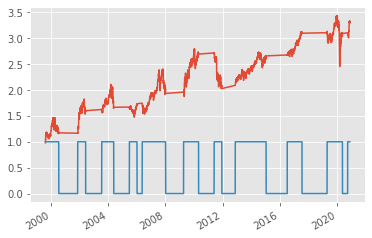

In [ ]:
backtest(120, 0.78, 0.39, 140, plot=True)